# How to be more realistic in our synthetic dataset?
---

In [201]:
import numpy as np
import matplotlib.pyplot as plt

def plot_power_spectrum(time_series, sampling_rate, threshold, axis):
    # Compute the FFT
    fft = np.fft.fft(time_series)
    
    # Compute the power spectrum
    power_spectrum = np.abs(fft)**2

    # Get the phase spectrum (argument of complex numbers)
    phase_spectrum = np.angle(fft)
    
    # Determine the corresponding frequencies
    frequencies = np.fft.fftfreq(len(time_series), 1/sampling_rate)
    
    # Find the indices of relevant frequencies above the threshold
    relevant_indices = np.where(power_spectrum > threshold)[0]
    
    # Extract the relevant frequencies and power spectrum values
    relevant_frequencies = frequencies[relevant_indices]
    relevant_power_spectrum = power_spectrum[relevant_indices]

    idx = np.argsort(relevant_frequencies)

    # Plot the power spectrum
    axis.plot(relevant_frequencies[idx], relevant_power_spectrum[idx])
    axis.set_xlabel('Frequency')
    axis.set_ylabel('Power Spectrum')
    axis.set_title('Power Spectrum')

    # Set x-axis limits to show positive frequencies only
    axis.set_xlim(0, max(relevant_frequencies))

    # Set y-axis scale to logarithmic for better visualization
    axis.set_yscale('log')
    return relevant_frequencies

In [202]:
from data._main import get_dataset
from omegaconf import OmegaConf

Chosen dataset(s): ['Flavell2023']
Num. worms: 50



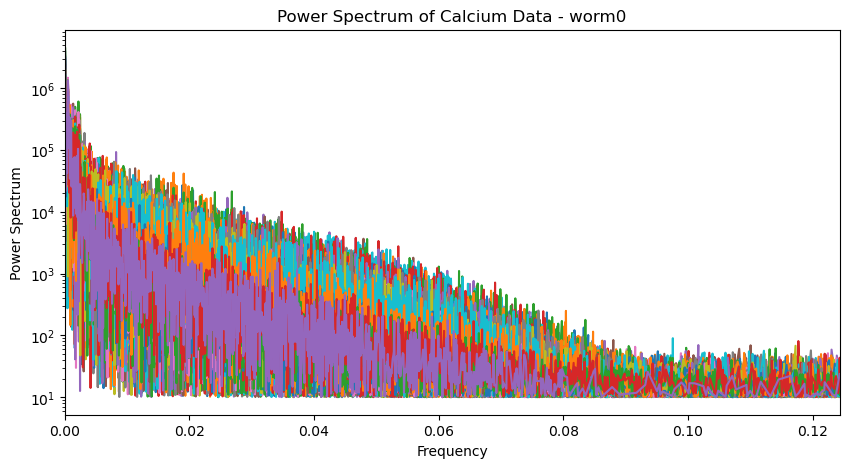

In [203]:
dataset = get_dataset(config=OmegaConf.load("/home/lrvnc/Projects/worm-graph/conf/dataset.yaml"))

for wormid in dataset.keys():
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    oneWorm = dataset[wormid]
    for named_neuron in oneWorm['slot_to_named_neuron']:
        ts1D = oneWorm['calcium_data'][:, named_neuron].detach().numpy()
        ps = plot_power_spectrum(ts1D, sampling_rate=0.25, threshold=10.0, axis=ax)
    
    plt.title("Power Spectrum of Calcium Data - {}".format(oneWorm['worm']))
    plt.show()
    if wormid == 'worm0':
        break

In [222]:
import numpy as np
from scipy.optimize import curve_fit
import torch

def approximate_exponential_decay(single_worm_dataset, plot=False):

    # Define the function to fit
    def func(x, a, b, c):
        return a * np.exp(-b * x) + c

    calcium = single_worm_dataset["calcium_data"]
    mask = single_worm_dataset["named_neurons_mask"]
    dt = single_worm_dataset["resample_median_dt"]

    data = calcium[:, mask]

    fft_data = torch.fft.rfft(data, dim=0)
    fft_freqs = torch.fft.rfftfreq(data.size(0), d=dt)

    # Convert fft_data and fft_freqs to numpy for use with curve_fit
    fft_data_np = fft_data.detach().numpy()
    fft_freqs_np = fft_freqs.detach().numpy()

    # Fit function to each column of data
    num_neurons = fft_data_np.shape[1]
    fit_params = np.zeros((num_neurons, 3))  # for a, b, and c
    for i in range(num_neurons):
        popt, pcov = curve_fit(func, fft_freqs_np, np.abs(fft_data_np[:, i]))
        fit_params[i, :] = popt # each row is a, b, and c for a neuron

    # Generate x values
    x = np.linspace(fft_freqs_np.min(), fft_freqs_np.max(), num=fft_freqs_np.size)

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot each fitted curve
    exponential_fits = np.zeros_like(fft_data_np)

    for i in range(num_neurons):
        # Generate y values for this curve
        exponential_fits[:, i] = func(x, *fit_params[i])
        # Plot the curve
        ax.plot(x, exponential_fits[:, i])

    if plot:
        plt.title("Exponential Decay Fits")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Squarred magnitude of FFT")
        plt.show()

    return exponential_fits, fit_params

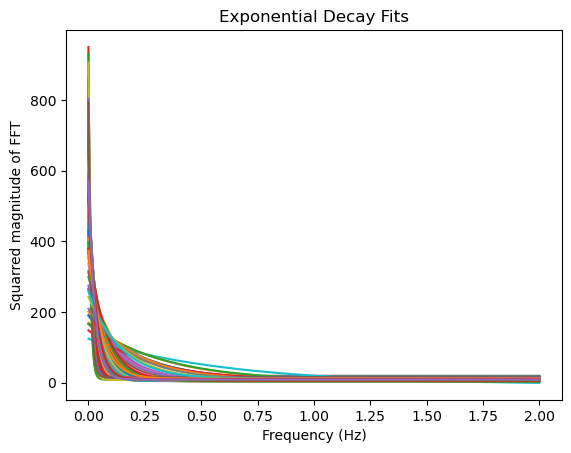

In [223]:
exponential_fits, fit_params = approximate_exponential_decay(dataset['worm0'], plot=True)

In [248]:
import numpy as np
import scipy.fftpack as fft

def synthesize_time_series(exponential_fits, time_steps, random_seed=42):
    """Create a synthetic time series given a power spectrum."""
    # Set a random seed for reproducibility, if provided
    if random_seed is not None:
        np.random.seed(random_seed)

    num_freqs = exponential_fits.shape[0]
    synthetic_data = np.zeros((time_steps, exponential_fits.shape[1]))

    for i in range(synthetic_data.shape[1]):
        # Generate a random phase spectrum
        phase_spectrum = np.random.normal(0.0, 1.8, num_freqs) # let's fix sigma to 1.8 for now
        # Combine the power and phase spectra
        freq_domain_signal = exponential_fits[:, i] * np.exp(1j * phase_spectrum)
        # Perform the inverse Fourier transform to get the time series
        synthetic_data[:, i] = fft.ifft(freq_domain_signal, n=time_steps).real

    return synthetic_data

In [249]:
synthetic_data = synthesize_time_series(exponential_fits, dataset['worm0']['calcium_data'].shape[0], random_seed=42)

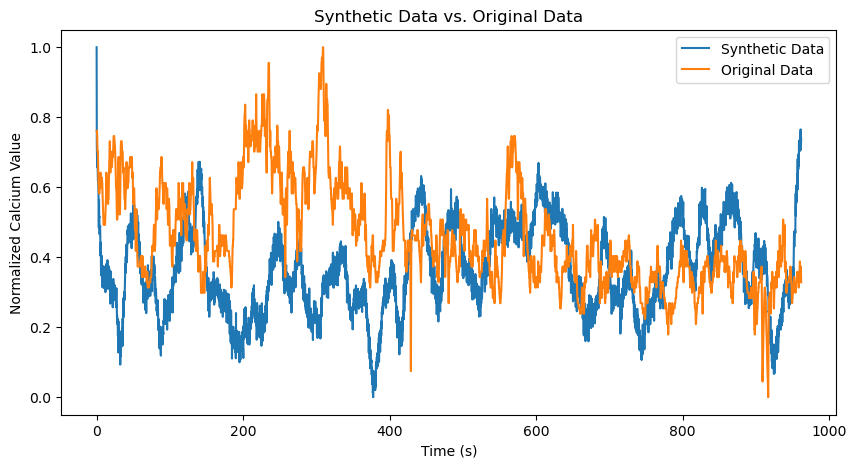

In [273]:
# Scale the synthetic data and original data with min_max scaling along dimension 0
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
synthetic_data = scaler.fit_transform(synthetic_data)
dataset['worm0']['calcium_data'] = scaler.fit_transform(dataset['worm0']['calcium_data'])

calcium_data = dataset['worm0']['calcium_data']
mask = dataset['worm0']['named_neurons_mask']
data = calcium_data[:, mask]

time_steps = data.shape[0]
time_vec = np.arange(time_steps) * 0.25

# Plot the synthetic data and original data
neuron_idx = 1
plt.figure(figsize=(10, 5))
plt.plot(time_vec, synthetic_data[:, neuron_idx], label='Synthetic Data')
plt.plot(time_vec, data[:, neuron_idx], label='Original Data')
plt.legend()
plt.title("Synthetic Data vs. Original Data")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Calcium Value")
plt.show()

In [209]:
from scipy.stats import norm

phase_distribution = np.zeros((302, 3)) # each column is the mu and sigma for a neuron (last column is the count)

for wormid in dataset.keys():
    calcium_data = dataset[wormid]["calcium_data"]
    mask = dataset[wormid]["named_neurons_mask"]
    dt = dataset[wormid]["resample_median_dt"]

    # Compute the FFT
    fft_data = torch.fft.rfft(calcium_data[:, mask], dim=0)
    fft_freqs = torch.fft.rfftfreq(calcium_data.size(0), d=dt)

    # Get the phase distribution
    phase_spectrum = np.angle(fft_data)

    for i, neuron_idx in enumerate(dataset[wormid]['slot_to_named_neuron']):
        # Fit a gaussian to the phase distribution
        mu, std = norm.fit(phase_spectrum[:, i])
        phase_distribution[neuron_idx, 0] += mu
        phase_distribution[neuron_idx, 1] += std
        phase_distribution[neuron_idx, 2] += 1

phase_distribution[:, 0] /= phase_distribution[:, 2]
phase_distribution[:, 1] /= phase_distribution[:, 2]
phase_distribution = phase_distribution[:, :2]
phase_distribution = np.nan_to_num(phase_distribution)
phase_distribution

array([[-2.76915166e-01,  1.45846634e+00],
       [-3.26107347e-01,  1.38040809e+00],
       [-2.02085365e-02,  1.72903873e+00],
       [ 2.79724397e-02,  1.80244877e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 1.07433636e-01,  1.83897911e+00],
       [ 1.00389088e-01,  1.88557954e+00],
       [ 2.35481158e-01,  1.95169783e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 2.26045816e-01,  1.88560691e+00],
       [ 1.14807326e-01,  1.88039323e+00],
       [-8.30746673e-02,  1.65764244e+00],
       [-1.20173886e-01,  1.61468720e+00],
       [-8.96952441e-02,  1.65566976e+00],
       [-1.16620973e-01,  1.64259281e+00],
       [-1.93224959e-01,  1.52908723e+00],
       [-1.06738713e-01,  1.66673421e+00],
       [ 2.86655536e-01,  1.93810933e+00],
       [ 2.68510822e-01,  1.95559643e+00],
       [-2.47515617e-02,  1.75472426e+00],
       [-9.41069944e-02,  1.67328178e+00],
       [ 1.71235220e-01,  1.91044952e+00],
       [ 0.

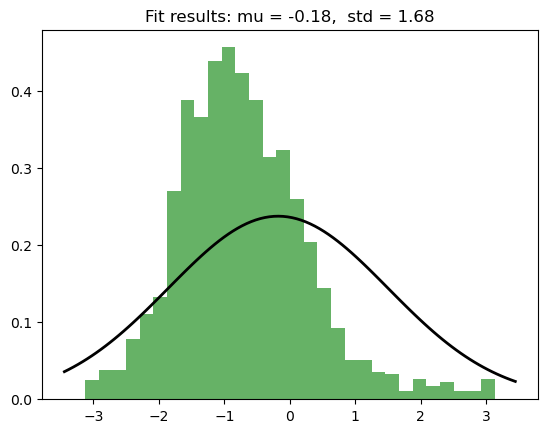

In [180]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

data = dataset['worm10']['calcium_data']
mask = dataset['worm10']['named_neurons_mask']
data = data[:, mask]
dt = oneWorm["resample_median_dt"]

neuron_idx = 0

fft_data = torch.fft.rfft(data, dim=0)
fft_freqs = torch.fft.rfftfreq(data.size(0), d=dt)

# Convert fft_data and fft_freqs to numpy for use with curve_fit
fft_data_np = fft_data.detach().numpy()
fft_freqs_np = fft_freqs.detach().numpy()

# Get the magnitude spectrum (absolute value of complex numbers)
magnitude_spectrum = np.abs(fft_data_np)

# Get the phase spectrum (argument of complex numbers)
phase_spectrum = np.angle(fft_data_np)

# Get the power spectrum (magnitude squared)
power_spectrum = np.square(magnitude_spectrum)

# Assuming phase_spectrum is your data
mu, std = norm.fit(phase_spectrum)

# Plot the histogram
plt.hist(phase_spectrum[:, neuron_idx], bins=30, density=True, alpha=0.6, color='g')

# Plot the PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

What is the phase distribution of a given neuron?

In [77]:
import numpy as np
import pickle
import random
from sklearn.preprocessing import StandardScaler
from preprocess._utils import smooth_data_preprocess, reshape_calcium_data
from utils import NEURONS_302


def create_synthetic_dataset(
    max_timesteps,
    num_worms=1,
    num_signal=302,
    num_named_neurons=302,
    if_noise=False,
    sum_frequencies=1,
    freq_gain=1.0,
    delta_seconds=0.10,
    noise_sd=0.01,
    transform=StandardScaler(),
    dataset_name="Synthetic0000",
):
    """
    Create synthetic worm datasets using a sum of sinusoidal functions.

    :param seq_len: The sequence length of the synthetic data.
    :param num_worms: The number of worms to create datasets for.
    :param num_signal: The number of signals, corresponds to number of neurons.
    :param num_named_neurons: The number of named neurons to create non-zero signals for.
    :param if_noise: If true, add Gaussian noise to the synthetic data.
    :param sum_frequencies: The number of sine functions to add together to create a signal.
    :param freq_gain: A multiplier for the frequencies of the calcium signal.
    :param delta_seconds: The constant time difference (in seconds) between each timepoint.
    :param transform: Standard deviation of the Gaussian noise.
    :param noise_sd: The sklearn transform to use for normalizing the data.
    :param dataset_name: The name to give the synthetic dataset.
    :return: A dictionary containing the synthetic worm datasets.
    """
    dataset = {}
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(
        -1, 1
    )  # Column vector

    # Create a memo of neurons to frequencies so that distinct neurons have distinct frequency signatures
    neuron_to_frequencies = dict()  # this will be consistent across worms

    # Create data for each worm
    for worm_idx in range(num_worms):
        # Create a memo of neurons to phases so that distinct neurons have distinct phase signatures
        neuron_to_phases = dict()  # this will vary across worms

        # Initialize worm data
        worm = f"worm{worm_idx}"
        worm_data = {}
        num_unknown_neurons = num_signal - num_named_neurons
        calcium_data = np.zeros((max_timesteps, num_signal))
        time_points = np.arange(max_timesteps)
        named_neuron_indices = random.sample(
            range(num_signal), num_named_neurons
        )  # random sampling without replacement
        named_neurons = set(NEURONS_302[i] for i in named_neuron_indices)

        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {
            (neuron) if neuron in named_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURONS_302)
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}

        # Create calcium data
        for i in named_neuron_indices:
            # TODO: Give each particular neuron a characteristic frequency that is consistent across worms
            neuron_name = NEURONS_302[i]
            frequencies = neuron_to_frequencies.setdefault(
                neuron_name,
                [
                    # freq_gain
                    # * np.random.uniform(
                    #     1.0 / max_timesteps, 10.0 / max_timesteps
                    # )  # random frequency
                    freq_gain * 4.0 / max_timesteps  # deterministic frequency
                    for _ in range(sum_frequencies)
                ],
            )
            phases = neuron_to_phases.setdefault(
                neuron_name,
                [
                    np.random.random() * 2 * np.pi  # random phase
                    # 0.5 * 2 * np.pi  # deterministic phase
                    for _ in range(sum_frequencies)
                ],
            )

            # Add sine functions
            for freq, phase in zip(frequencies, phases):
                calcium_data[:, i] += np.sin(2 * np.pi * freq * time_points + phase)

            # Add noise
            if if_noise:
                calcium_data[:, i] += np.random.normal(0, noise_sd, max_timesteps)

        # Normalize data
        calcium_data = transform.fit_transform(calcium_data)

        # Smooth the data
        smooth_method = "FFT"
        smooth_calcium_data = smooth_data_preprocess(
            calcium_data, time_in_seconds, smooth_method
        )
        dt = np.gradient(time_in_seconds, axis=0)
        dt[dt == 0] = np.finfo(float).eps
        original_dt = np.median(dt).item()
        resample_dt = delta_seconds
        residual_calcium = np.gradient(calcium_data, axis=0) / dt
        smooth_residual_calcium = smooth_data_preprocess(
            residual_calcium, time_in_seconds, smooth_method
        )

        # Save the data
        worm_data["dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["worm"] = worm
        worm_data["calcium_data"] = calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["original_median_dt"] = original_dt
        worm_data["resample_median_dt"] = resample_dt
        worm_data["max_timesteps"] = max_timesteps
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["num_neurons"] = num_signal
        worm_data["num_named_neurons"] = num_named_neurons
        worm_data["num_unknown_neurons"] = num_unknown_neurons

        worm_data = reshape_calcium_data(worm_data)

        dataset[worm] = worm_data

    return dataset


def save_synthetic_dataset(file_name, datasets):
    with open(file_name, "wb") as f:
        pickle.dump(datasets, f)


max_timesteps = 3000
num_worms = 10
num_signal = 302
num_named_neurons = 302
file_name = "Synthetic0000"

# Creating and saving datasets
dataset = create_synthetic_dataset(
    max_timesteps,
    num_worms,
    num_signal,
    num_named_neurons,
    if_noise=False,
    sum_frequencies=1,
    freq_gain=1.0,
    delta_seconds=0.25,
    noise_sd=0.20,
    transform=StandardScaler(),
    dataset_name=file_name,
)
save_synthetic_dataset(f"../data/processed/neural/{file_name}.pickle", dataset)

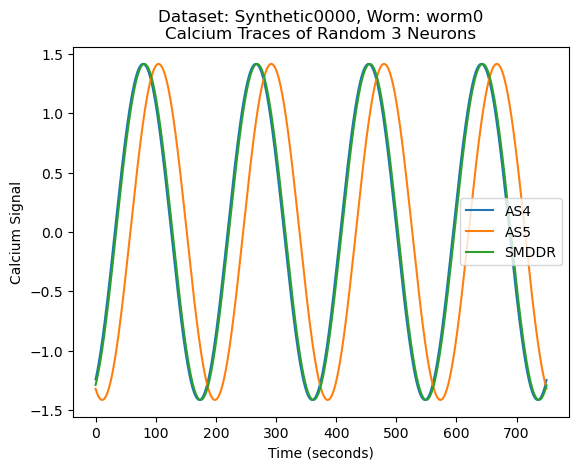

In [78]:
import pickle
from visualize._utils import plot_worm_data

# Load synthetic dataset
with open(f"../data/processed/neural/{file_name}.pickle", "rb") as f:
    dataset = pickle.load(f)

# Plot the first few calcium traces for the first worm
plot_worm_data(dataset["worm0"], num_neurons=3, smooth=False)